In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from customized import preprocess
from customized.model import neural_network
from striatum import MAB
from striatum.storage.action import Action
import importlib
importlib.reload(neural_network)

<module 'customized.model.neural_network' from '/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/neural_network.py'>

In [31]:
latent_vector = np.load('data/latent_vector.npy')
static_context = np.load('data/static_context.npy')
temporal_context = np.load('data/temporal_context.npy')
cust_id = np.load('data/cust_id2.npy')
sub_txn = pd.read_pickle('data/sub_txn.pkl')
streamer = pd.read_pickle('data/streamer.pkl')
# full_context_mab = np.load('data/full_context_mab.npy')
mab_latent = np.load('data/mab_latent.npy')
end_date = '2021-11-01'
next_date = '2021-11-02'
sequence_length=10 # 取小的
prod_t, trim_cust_list = preprocess.trim_cust_prod_n(sequence_length, sub_txn, end_date)

In [8]:
rec_prod_df = {}
data = {}
reward_df = {}
cust_has_ans_list = []
all_products = []
li = []
all_streamer_product = []
user = list(sorted(set(sub_txn.user_id)))

for u in user:
    rec_prod_df[u], rec_prod_list_all = preprocess.get_rec_prod_list(u, sub_txn, next_date)
    for channel in [rec_prod_df[u]]:
        _, data['super_like_'+str(u)], data['super_like_prod_id_'+str(u)], data['super_like_cust_id_'+str(u)], \
        _, _, _, \
        data['potential_like_'+str(u)], data['potential_like_prod_id_'+str(u)], data['potential_like_cust_id_'+str(u)] = \
        preprocess.channel_answer(u, channel, sub_txn, prod_t, sequence_length, next_date, trim_cust_list)
    cust_has_ans_list += data['super_like_cust_id_'+str(u)] + data['potential_like_cust_id_'+str(u)]
    all_products += data['super_like_prod_id_'+str(u)] + data['potential_like_prod_id_'+str(u)]
    # reward table
    reward_df[str(u)] = preprocess.generate_reward_df(data['super_like_'+str(u)], data['potential_like_'+str(u)])
    li.append(reward_df[str(u)])
    reward_list = pd.pivot_table(data=reward_df[str(u)], index='asid', columns='商品id', values="reward", fill_value=0)
    # streamer-product features
    prod_id_reward = list(reward_list.columns)
    prod_feature = preprocess.id2embed(prod_id_reward)
    streamer_feature = streamer[streamer.index==u].to_numpy()
    print(f"streamer: {streamer_feature.shape}, product: {prod_feature.shape}")
    repeat_streamer = np.repeat(streamer_feature, prod_feature.shape[0], axis=0)
    streamer_product = np.concatenate((repeat_streamer, prod_feature), axis=1)
    all_streamer_product.append(streamer_product)
cust_has_ans_list = list(set(cust_has_ans_list))
all_reward_df = pd.concat(li, axis=0, ignore_index=True)
all_reward_pivot = pd.pivot_table(data=all_reward_df, index='asid', columns='商品id', values="reward", fill_value=0) # (2602, 1023)
all_streamer_product = np.concatenate(all_streamer_product, axis=0)
print(f'全部共: {len(cust_has_ans_list)} 人有答案 ({(len(cust_has_ans_list)/len(trim_cust_list) * 100):.2f}%)')
print(f'全部共: {len(set(all_products))} 個商品')
print(f"all streamer-product features: {all_streamer_product.shape}")

=====
頻道 10891 在下一場直播中共有 597 個商品
[一年內有買] 商品數: 436, 人數: 459
[在t+1時有買] 商品數: 284, 人數: 405
[非t+1但半年內有買] 商品數: 136, 人數: 147
有 2193 個人沒有答案; 437 人有答案
streamer: (1, 23), product: (370, 768)
=====
頻道 12235 在下一場直播中共有 76 個商品
[一年內有買] 商品數: 56, 人數: 53
[在t+1時有買] 商品數: 25, 人數: 41
[非t+1但半年內有買] 商品數: 19, 人數: 21
有 2581 個人沒有答案; 49 人有答案
streamer: (1, 23), product: (38, 768)
=====
頻道 4460 在下一場直播中共有 110 個商品
[一年內有買] 商品數: 6, 人數: 7
[在t+1時有買] 商品數: 4, 人數: 5
[非t+1但半年內有買] 商品數: 1, 人數: 1
有 2624 個人沒有答案; 6 人有答案
streamer: (1, 23), product: (5, 768)
=====
頻道 4793 在下一場直播中共有 72 個商品
[一年內有買] 商品數: 58, 人數: 159
[在t+1時有買] 商品數: 40, 人數: 150
[非t+1但半年內有買] 商品數: 14, 人數: 29
有 2479 個人沒有答案; 151 人有答案
streamer: (1, 23), product: (47, 768)
=====
頻道 6112 在下一場直播中共有 246 個商品
[一年內有買] 商品數: 115, 人數: 59
[在t+1時有買] 商品數: 37, 人數: 22
[非t+1但半年內有買] 商品數: 44, 人數: 37
有 2586 個人沒有答案; 44 人有答案
streamer: (1, 23), product: (70, 768)
=====
頻道 6835 在下一場直播中共有 397 個商品
[一年內有買] 商品數: 393, 人數: 561
[在t+1時有買] 商品數: 211, 人數: 536
[非t+1但半年內有買] 商品數: 128, 人數: 19
有 2093 個人沒有答案; 537 人

# Product Recommendation

In [32]:
lers_ae_context, lers_ae_context_id, lers_ae_context_dict = preprocess.trim_cust_for_context(latent_vector, cust_id, cust_has_ans_list)
lers_stat_context, lers_stat_context_id, lers_stat_context_dict = preprocess.trim_cust_for_context(static_context, cust_id, cust_has_ans_list)
lers_temp_context, lers_temp_context_id, lers_temp_context_dict = preprocess.trim_cust_for_context(temporal_context, cust_id, cust_has_ans_list)
mab_context, mab_context_id, mab_context_dict = preprocess.trim_cust_for_context(mab_latent, cust_id, cust_has_ans_list)

In [13]:
nn_regret_ae, nn_rewards_ae, nn_highest_idxs_ae = neural_network.run(lers_ae_context, all_streamer_product, all_reward_pivot)

放入1023個商品
round: 0
round: 5
round: 10
round: 15
round: 20
round: 25
round: 30
round: 35
round: 40
round: 45
round: 50
round: 55
round: 60
round: 65
round: 70
round: 75
round: 80
round: 85
round: 90
round: 95
round: 100
round: 105
round: 110
round: 115
round: 120
round: 125
round: 130
round: 135
round: 140
round: 145
round: 150
round: 155
round: 160
round: 165
round: 170
round: 175
round: 180
round: 185
round: 190
round: 195
round: 200
round: 205
round: 210
round: 215
round: 220
round: 225
round: 230
round: 235
round: 240
round: 245
round: 250
round: 255
round: 260
round: 265
round: 270
round: 275
round: 280
round: 285
round: 290
round: 295
round: 300
round: 305
round: 310
round: 315
round: 320
round: 325
round: 330
round: 335
round: 340
round: 345
round: 350
round: 355
round: 360
round: 365
round: 370
round: 375
round: 380
round: 385
round: 390
round: 395
round: 400
round: 405
round: 410
round: 415
round: 420
round: 425
round: 430
round: 435
round: 440
round: 445
round: 450
round: 455


In [10]:
nn_regret_stat, nn_rewards_stat, nn_highest_idxs_stat = neural_network.run(lers_stat_context, all_streamer_product, all_reward_pivot)

放入1023個商品
round: 0
round: 1
round: 2
round: 3
round: 4
round: 5
round: 6
round: 7
round: 8
round: 9
round: 10
round: 11
round: 12
round: 13
round: 14
round: 15
round: 16
round: 17
round: 18
round: 19
round: 20
round: 21
round: 22
round: 23
round: 24
round: 25
round: 26
round: 27
round: 28
round: 29
round: 30
round: 31
round: 32
round: 33
round: 34
round: 35
round: 36
round: 37
round: 38
round: 39
round: 40
round: 41
round: 42
round: 43
round: 44
round: 45
round: 46
round: 47
round: 48
round: 49
round: 50
round: 51
round: 52
round: 53
round: 54
round: 55
round: 56
round: 57
round: 58
round: 59
round: 60
round: 61
round: 62
round: 63
round: 64
round: 65
round: 66
round: 67
round: 68
round: 69
round: 70
round: 71
round: 72
round: 73
round: 74
round: 75
round: 76
round: 77
round: 78
round: 79
round: 80
round: 81
round: 82
round: 83
round: 84
round: 85
round: 86
round: 87
round: 88
round: 89
round: 90
round: 91
round: 92
round: 93
round: 94
round: 95
round: 96
round: 97
round: 98
round: 99


In [35]:
neural_network.run(lers_stat_context, all_streamer_product, all_reward_pivot)

放入1023個商品


  0%|          | 0/2602 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
from tqdm.notebook import tqdm
for i in tqdm(range(10)):
    print(i)

  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


In [11]:
nn_regret_temp, nn_rewards_temp, nn_highest_idxs_temp = neural_network.run(lers_temp_context, all_streamer_product, all_reward_pivot)

放入1023個商品
round: 0
round: 1
round: 2
round: 3
round: 4
round: 5
round: 6
round: 7
round: 8
round: 9
round: 10
round: 11
round: 12
round: 13
round: 14
round: 15
round: 16
round: 17
round: 18
round: 19
round: 20
round: 21
round: 22
round: 23
round: 24
round: 25
round: 26
round: 27
round: 28
round: 29
round: 30
round: 31
round: 32
round: 33
round: 34
round: 35
round: 36
round: 37
round: 38
round: 39
round: 40
round: 41
round: 42
round: 43
round: 44
round: 45
round: 46
round: 47
round: 48
round: 49
round: 50
round: 51
round: 52
round: 53
round: 54
round: 55
round: 56
round: 57
round: 58
round: 59
round: 60
round: 61
round: 62
round: 63
round: 64
round: 65
round: 66
round: 67
round: 68
round: 69
round: 70
round: 71
round: 72
round: 73
round: 74
round: 75
round: 76
round: 77
round: 78
round: 79
round: 80
round: 81
round: 82
round: 83
round: 84
round: 85
round: 86
round: 87
round: 88
round: 89
round: 90
round: 91
round: 92
round: 93
round: 94
round: 95
round: 96
round: 97
round: 98
round: 99


In [14]:
nn_regret_ae[-1], nn_regret_stat[-1], nn_regret_temp[-1] # 22:09-23:18

(0.0127, 0.0196, 0.0027)

In [20]:
np.save('data/nn_regret', nn_regret)

ae's regret of 1023 products: 0.0127
static's regret of 1023 products: 0.0196
temporal's regret of 1023 products: 0.0027


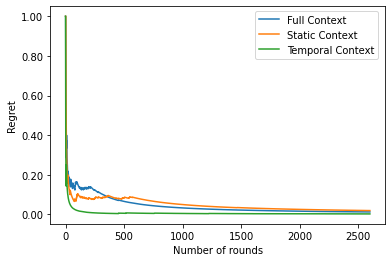

In [19]:
nn_regret = {}
mylabel = ['Full Context', 'Static Context', 'Temporal Context']
for cxt in ['ae','static','temporal']:
    if cxt == 'ae':
        nn_regret[cxt] = nn_regret_ae
    elif cxt == 'static':
        nn_regret[cxt] = nn_regret_stat
    else:
        nn_regret[cxt] = nn_regret_temp
    print(f"{cxt}'s regret of 1023 products: {nn_regret[cxt][-1]}")
    plt.plot(range(2602), nn_regret[cxt], ls='-', label=cxt)
    plt.ylabel('Regret')
    plt.xlabel('Number of rounds')
    plt.legend(labels=mylabel, bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0.)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.savefig(fname='./fig/lers_context.pdf', dpi=300, format='pdf')
plt.show()

1023 products: 0.0015


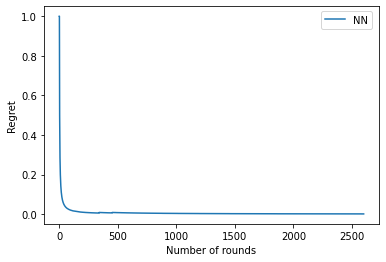

In [311]:
# print("1023 products:", nn_regret[-1])
# plt.plot(range(n_total_steps), nn_regret, ls='-', label='NN')
# plt.ylabel('Regret')
# plt.xlabel('Number of rounds')
# plt.legend(labels=['NN'], bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0.)
# plt.savefig(fname='./fig/nn_1023.pdf', dpi=300, format='pdf')
# plt.show()

In [307]:
# np.save('data/nn_regret.npy', nn_regret)

# MAB

In [24]:
def main(num, full_context, context_id, answer, streamer_proudct, lers_input_regret): # 2602人, 815dim
    
    rewards = pd.pivot_table(data=answer, index='asid', columns='商品id', values="reward", fill_value=0)
    actions = []
    for prod_id in streamer_proudct:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
#     experiment_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'LERS']
    experiment_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3', 'LERS']
    regret = {}
    overall_cr_dict = {} # 2021/01/31 Rita
    col = [  'c','g', 'r', 'm','b', 'k', 'w']
#     col = [  'c','g', 'r', 'm','y', 'b', 'k', 'w']
    ls = ['-','-',':','--','-','-.']
    i = 0
#     mylabel = ['Random', 'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB','LERS']
    mylabel = ['Random', 'UCB1', 'LinUCB', 'Exp3','LERS']

    for bandit in experiment_bandit:
        print(bandit)            
        if (bandit != 'NeuralUCB') & (bandit != 'LERS'):        
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
        else:
#             neuralUCB_regret, neuralUCB_reward_df = neuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=100, use_cuda=False, seed=np.random.seed(2022))
            regret['LERS'] = lers_input_regret[:num]            
        print("-----")
        
        ## plot regret ##
        plt.plot(range(num), regret[bandit], c=col[i], ls='-', label=bandit)
        plt.ylabel('Regret')
        plt.xlabel('Number of rounds')
        plt.legend(labels=mylabel, bbox_to_anchor=(0.98, 0.98), loc=1, borderaxespad=0.)
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
#         plt.gca().set_ylim([0, 1])
        i += 1
    plt.savefig(fname='./fig/nn.pdf', dpi=300, format='pdf')
    plt.show()
    
    for bandit in experiment_bandit:
        print(bandit, regret[bandit][-1])
    return regret, rec_id 

## blurry_context

user features: (2602, 20), reward targets: (2602, 1023)
random
Correct 3
-----
UCB1
Correct 0
2977690    261
2611434    261
4634467    260
4298065    260
4894967    260
3143734    260
2977759    260
4594867    260
4318090    260
4055482    260
dtype: int64
-----
LinUCB
Correct 4
2611434    2602
dtype: int64
-----
Exp3
Correct 3
Series([], dtype: int64)
-----
LERS
-----


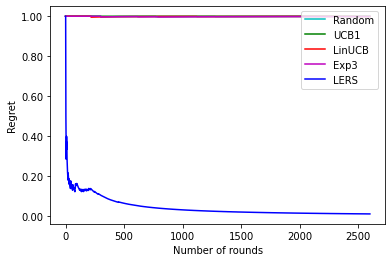

random [0.99884704]
UCB1 [1.]
LinUCB [0.99846272]
Exp3 [0.99884704]
LERS 0.0127


In [33]:
importlib.reload(MAB)
lers_input_regret = nn_regret_ae
regret, rec_id = main(len(mab_context_id), mab_context, mab_context_id, all_reward_df, prod_id_reward[:10], lers_input_regret) 
# LinUCB dim如果太高就最花時間, 11:50~11:59, 所以先降維會變超快

In [425]:
pd.Series(rec_id).value_counts()

4298065    297
4594867    284
4634467    278
3143734    262
2611434    258
2977690    256
4055482    252
4894967    239
2977759    238
4318090    238
dtype: int64